TODO
* add table DB with common message information like SA, CAN
* link tables with message ID that should inlcude CAN channel and be unique
* create DBC DB to work as util - give messages by ID and vice verca. Parse messages with raw data. 
* select storage export format for further analysis in other tools and import back. DONE: mdf itself is the best+csv as human readable
* 2 group of analisys - time and meta message info (wo signal values) and with message values 
* refactor the code - get statistics at first for each group of files, then aggregate them into one and calc diff separately

* add validation flags processing
* add app versions to meta informations if its possible to parse




In [1]:
# imports and example settings
%load_ext autoreload
%autoreload 2
import warnings
from asammdf import MDF
from cantools import db
import canmatrix.formats
import pandas as pd
from collections import defaultdict
from etils import ecolab
import matplotlib.pyplot as plt
import numpy as np
from asammdf.blocks import v4_constants as v4c
from asammdf.blocks import bus_logging_utils
import sys
import os
# from utils import setup_fs, load_dbc_files, restructure_data, add_custom_sig, ProcessData, test_signal_threshold
import can_decoder
from pathlib import Path
import re
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio
from tabulate import tabulate
import  utils.can_log_utils as utls
from utils.dbc_db import DbcDb

import logging
logging.getLogger('asammdf').setLevel(logging.DEBUG)

%connect_info


ldf is not supported
xls is not supported
xlsx is not supported


{"key":"aaa721f8-403d-4cd3-8fe5-a3aeb85209a6","signature_scheme":"hmac-sha256","transport":"tcp","ip":"127.0.0.1","hb_port":9050,"control_port":9051,"shell_port":9052,"stdin_port":9053,"iopub_port":9054,"kernel_name":"python3127jvsc74a57bd0e7c25480a53691149789381bdda99fb7f8d344b19173f1535ebe8bfb62cf4ee5"}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing c:\Users\meleshin\AppData\Roaming\jupyter\runtime\kernel-v3558ae1c74aabe696015524d4fc45b02916993414.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:

# file1=r'C:\D\downloads\VI-15803\R11_canlog_50638_20240926_142426_trace.mdf'
# file2=r'C:\D\downloads\VI-15803\R12_D19_2024-10-31_10-48-44_trace.mdf'
# file1=r'C:\D\downloads\VI-15803\R11_canlog_50638_20240926_142426.mf4'
# file2=r'C:\D\downloads\VI-15803\R12_D19_2024-10-31_10-48-44.mf4'
# file1=r'C:\D\downloads\VI-15803\vcd_11_30082024.mf4'
# file2=r'C:\D\downloads\VI-15803\vcd_12_drop2_27_09_24.mf4'
# file1=r'C:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\input\r11_D19\R11_canlog_50640_20240926_142715.mf4'
# file2=r'C:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\input\r12_D19\canlog_51940_20241107_122852.mf4'

log_file1=r'C:\d\Downloads\VI-15803\R12_D19_2024-10-31_10-48-44.mf4'
log_file2=r'C:\d\Downloads\VI-15803\R12_D19_2024-10-31_10-48-44.mf4'


dbc_dir=r'C:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\dbc\ucs_dbc-0.12.0.0'
CAN_MAPS_FILE=r'C:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\input\VAN_CAN_MAPS.xlsx'
CAN_MAPS_SHEETNAME='R12_COMM_MAP'
f1_time=[12,22] # selection of the log
f2_time=[12,22] # selection of the log
f1_can_maps={'CAN2_VEH':2,'CAN7_BRK':3}
f2_can_maps={'CAN2_VEH':2,'CAN7_BRK':3}
# # init_notebook_mode(connected=True)  
pio.renderers.default = "notebook"

In [3]:
mdf1 = MDF(log_file1)
mdf2 = MDF(log_file2)

In [4]:
mdf1=mdf1.cut(f1_time[0],f1_time[1],whence=1,time_from_zero=1)
mdf2=mdf2.cut(f2_time[0],f2_time[1],whence=1,time_from_zero=1)

In [5]:
dbc_files=Path(dbc_dir).glob("*.dbc")
dbc_files_list=list(dbc_files)
CAN_MAP=pd.read_excel(CAN_MAPS_FILE,sheet_name=CAN_MAPS_SHEETNAME,true_values=[1],false_values=[0])
CAN_MAP.fillna(value=False,inplace=True)
CAN_MAP = CAN_MAP.replace(1, True)
CAN_MAP = CAN_MAP.replace(0, False)
CAN_MAP.head();

C:\Users\meleshin\AppData\Local\Temp\ipykernel_34572\3300216909.py:4: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\meleshin\AppData\Local\Temp\ipykernel_34572\3300216909.py:4: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\meleshin\AppData\Local\Temp\ipykernel_34572\3300216909.py:5: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,dbc_file,CAN1,CAN2_VEH,CAN3,CAN4,CAN5,CAN6,CAN7_BRK,CAN8
0,Actia_eCall_CAN.dbc,False,False,False,False,False,False,False,False
1,ACU_Arrival.dbc,False,False,False,False,False,False,True,False
2,ADAS_Data.dbc,False,False,False,False,False,False,False,False
3,ADAS_FlashData.dbc,False,False,False,False,False,False,False,False
4,ADAS_Telemetry.dbc,False,False,False,False,False,False,False,False


In [6]:
# def get_can_map(dbc_files_list, CAN_MAP,CH_NAME):
#     CAN_SEL=CAN_MAP[CAN_MAP[CH_NAME]][['dbc_file',CH_NAME]]

#     filtered_files = CAN_SEL['dbc_file'].tolist()

#     # Get a list of file names from the files list for easy lookup
#     available_file_names = {file.name: file for file in dbc_files_list}

#     # Initialize a list for matching paths
#     CAN_PTHS = []

#     # Iterate over filtered_files and check if each file is in available_file_names
#     for dbc_file in filtered_files:
#         if dbc_file in available_file_names:
#             # Add the matching path if found
#             CAN_PTHS.append(available_file_names[dbc_file])
#         else:
#             # Print a warning if the file is not found in the list
#             print(f"Warning: {dbc_file} not found in the available files list.")
#     # Print the matching paths
#     # print("Matching paths:")
#     # print(CAN_PTHS)
#     return CAN_PTHS

# CAN_BRK=get_can_map(dbc_files_list,CAN_MAP,'CAN7_BRK')
# CAN_VEH=get_can_map(dbc_files_list,CAN_MAP,'CAN2_VEH');

# DBC2CAN_MAPS_FILE=r'input\VAN_CAN_MAPS.xlsx'
# can2ch_maps={'CAN2_VEH':2,'CAN7_BRK':7}
# (CAN_MAP,can_db1)=utls.get_can_map2extract(dbc_dir,can2ch_maps,DBC2CAN_MAPS_FILE=r'input\VAN_CAN_MAPS.xlsx'
# )
# print(can_db1)
# CAN_MAP.head()

In [7]:
# can_db1=[(path,f1_can_maps['VEH']) for path in CAN_VEH]
# can_db2=[(path,f2_can_maps['VEH']) for path in CAN_VEH]

# can_db1_brk=[(path,f1_can_maps['BRK']) for path in CAN_BRK]
# can_db2_brk=[(path,f2_can_maps['BRK']) for path in CAN_BRK]

# can_db1.extend(can_db1_brk)
# can_db2.extend(can_db2_brk)
# can_db2;

(CAN_MAP1,can_db1)=utls.get_can_map2extract(dbc_dir,f1_can_maps,DBC2CAN_MAPS_FILE=CAN_MAPS_FILE,map_sheet_name=CAN_MAPS_SHEETNAME)

(CAN_MAP2,can_db2)=utls.get_can_map2extract(dbc_dir,f2_can_maps,DBC2CAN_MAPS_FILE=CAN_MAPS_FILE,map_sheet_name=CAN_MAPS_SHEETNAME)


# print(can_db1)
# CAN_MAP.head()

c:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\utils\can_log_utils.py:694: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

c:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\utils\can_log_utils.py:694: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [8]:
# databases1 = {
#     "CAN": can_db1, # map to channel 2 - Body CAN
# }

# databases2 = {
#     "CAN": can_db2, # map to channel 2 - Body CAN
# }

# databases_all = {"CAN": [(dbc, 0) for dbc in list(Path(dbc_dir).glob("*.dbc"))]}

In [9]:
print('CAN log 1')
mdf1_extracted = mdf1.extract_bus_logging(database_files=can_db1)


import re
mdf1_msgs=defaultdict(lambda: defaultdict(list))
mdf1_msgs_grp=defaultdict(lambda: defaultdict(int))
mdf1_can_sa_msgs_grp=defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
mdf1_can_sa_msgs=defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
mdf1_can_sa_msgs_sigs_idx=defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(tuple))))
#                               can             sa                  msg                 sig

mdf1_all_signames=[list(can_signal.display_names.keys())[0] for can_signal in mdf1_extracted]

for can_signal in mdf1_extracted:
    # print(can_signal.display_names)
    can_msg_sig=list(can_signal.display_names.keys())[0]
    msg=can_msg_sig.split('.')
    m_can=msg[0]
    m_msg=msg[1]
    m_sig=msg[2]
    src=can_signal.source.name
    src_sa='NO'
    m_gr_ch_idx=(can_signal.group_index, can_signal.channel_index)
    if 'SourceAddress' in src:
        # get SA address of the sender
        if '0x' in src:
            m=src.split('0x')
            if len(m)>1:
                src_sa=m[1]
            else:
                src_sa=src
        else:
                src_sa=src
            

        # m=re.search(r'0x\w+',src)
        m=mdf1_can_sa_msgs
        # if m:
        #     src_sa=m[0]
        # else:
        #     src_sa=src
    else:
        src_sa='0x0'
    if msg[2] not in  mdf1_can_sa_msgs[msg[0]][src_sa][msg[1]]:
        mdf1_can_sa_msgs[msg[0]][src_sa][msg[1]].append(msg[2])
        
    if m_sig not in  mdf1_can_sa_msgs_sigs_idx[m_can][src_sa][m_msg]:
        mdf1_can_sa_msgs_sigs_idx[m_can][src_sa][m_msg][m_sig]=m_gr_ch_idx
        
    if msg[2] not in mdf1_msgs[msg[0]][msg[1]]:
        mdf1_msgs[msg[0]][msg[1]].append(msg[2])
    # detect multiple groups
    grp_sig_id=mdf1_extracted.channels_db[can_msg_sig]
    grp_sig_id_sum=sum(len(x) for x in grp_sig_id)
    if grp_sig_id_sum>2:
    # if mdf1_msgs_grp[msg[0]][msg[1]]:
        warnings.warn(f"group already exist for {can_signal.display_names} {grp_sig_id}. Take the first one")
        # grp_sig_id=grp_sig_id[0]
        # grp_sig_id[0];
        
    # mdf1_msgs_grp[msg[0]][msg[1]]=can_signal.group_index
    mdf1_msgs_grp[msg[0]][msg[1]]=grp_sig_id[0][0]
    mdf1_can_sa_msgs_grp[msg[0]][src_sa][msg[1]]=grp_sig_id[0][0]

mdf1_msgs_grp;
mdf1_msgs;


print('\n\nCAN log 2')
    
mdf2_extracted = mdf2.extract_bus_logging(database_files=can_db2)
# mdf2_extracted = mdf2.extract_bus_logging(database_files=databases_all)
mdf2_msgs=defaultdict(lambda: defaultdict(list))

for can_signal in mdf2_extracted:
    print(can_signal.display_names)
    msg=list(can_signal.display_names.keys())[0].split('.')
    # msgs2.append(msg)
    mdf2_msgs[msg[0]][msg[1]].append(msg[2])
    
# print(list(msgs2.keys())) 

CAN log 1


C:\Users\meleshin\AppData\Local\Temp\ipykernel_34572\3635561689.py:58: UserWarning:

group already exist for {'CAN3.CLU_ID5.IDENTIFICATION_NUMBER_0': 'bus', 'CLU_ID5.IDENTIFICATION_NUMBER_0': 'message'} ((56, 1), (61, 1)). Take the first one

C:\Users\meleshin\AppData\Local\Temp\ipykernel_34572\3635561689.py:58: UserWarning:

group already exist for {'CAN3.CLU_ID5.IDENTIFICATION_NUMBER_4': 'bus', 'CLU_ID5.IDENTIFICATION_NUMBER_4': 'message'} ((56, 2), (61, 2)). Take the first one

C:\Users\meleshin\AppData\Local\Temp\ipykernel_34572\3635561689.py:58: UserWarning:

group already exist for {'CAN3.CLU_ID5.IDENTIFICATION_NUMBER_3': 'bus', 'CLU_ID5.IDENTIFICATION_NUMBER_3': 'message'} ((56, 3), (61, 3)). Take the first one

C:\Users\meleshin\AppData\Local\Temp\ipykernel_34572\3635561689.py:58: UserWarning:

group already exist for {'CAN3.CLU_ID5.IDENTIFICATION_NUMBER_2': 'bus', 'CLU_ID5.IDENTIFICATION_NUMBER_2': 'message'} ((56, 4), (61, 4)). Take the first one

C:\Users\meleshin\AppData\Lo

defaultdict(<function __main__.<lambda>()>,
            {'CAN2': defaultdict(int,
                         {'DTS_Status1': 0, 'GS_State': 1, 'VSMState': 2}),
             'CAN3': defaultdict(int,
                         {'ACM_2': 3,
                          'YRS_1': 4,
                          'YRS_2': 5,
                          'ACM_1': 6,
                          'EDR_1': 7,
                          'EDR_2': 8,
                          'BRK_Status1': 9,
                          'IBC_Driven_Wheel_Velocity': 10,
                          'IBC_NonDriven_Wheel_Velocity': 11,
                          'EPS_Steering_Wheel_Angle': 12,
                          'EPS_Info': 13,
                          'EPS_AD_Switch': 14,
                          'EPS_CloudMsg_1': 15,
                          'EPS_CloudMsg_2': 16,
                          'EPS_FD_Data': 17,
                          'IBC_Vehicle_Info_2': 18,
                          'DCDC12_Info_1': 19,
                        

defaultdict(<function __main__.<lambda>()>,
            {'CAN2': defaultdict(list,
                         {'DTS_Status1': ['DTS_Standstill',
                           'DT_ReadyToSleep',
                           'DTS_SystemStatus',
                           'DTS_AccrPedlSw',
                           'DTS_BrkPedlPosn',
                           'DTS_IgnitionStatus',
                           'DTS_BrkPedlSw',
                           'DTS_VehicleSpeed',
                           'DTS_AccrPedlPosn',
                           'DTS_VehMoveDir',
                           'DTS_ReadyToSleep',
                           'DTS_ReadyToDrive',
                           'DTS_Status1_checksum',
                           'DTS_Status1_counter'],
                          'GS_State': ['GS_VSMInhibits',
                           'GS_CRC',
                           'GS_MC',
                           'GS_Inhibits',
                           'Warn_Mvlck_NA',
                           'I



CAN log 2
{'CAN2.DTS_Status1.DTS_Standstill': 'bus', 'DTS_Status1.DTS_Standstill': 'message'}
{'CAN2.DTS_Status1.DT_ReadyToSleep': 'bus', 'DTS_Status1.DT_ReadyToSleep': 'message'}
{'CAN2.DTS_Status1.DTS_SystemStatus': 'bus', 'DTS_Status1.DTS_SystemStatus': 'message'}
{'CAN2.DTS_Status1.DTS_AccrPedlSw': 'bus', 'DTS_Status1.DTS_AccrPedlSw': 'message'}
{'CAN2.DTS_Status1.DTS_BrkPedlPosn': 'bus', 'DTS_Status1.DTS_BrkPedlPosn': 'message'}
{'CAN2.DTS_Status1.DTS_IgnitionStatus': 'bus', 'DTS_Status1.DTS_IgnitionStatus': 'message'}
{'CAN2.DTS_Status1.DTS_BrkPedlSw': 'bus', 'DTS_Status1.DTS_BrkPedlSw': 'message'}
{'CAN2.DTS_Status1.DTS_VehicleSpeed': 'bus', 'DTS_Status1.DTS_VehicleSpeed': 'message'}
{'CAN2.DTS_Status1.DTS_AccrPedlPosn': 'bus', 'DTS_Status1.DTS_AccrPedlPosn': 'message'}
{'CAN2.DTS_Status1.DTS_VehMoveDir': 'bus', 'DTS_Status1.DTS_VehMoveDir': 'message'}
{'CAN2.DTS_Status1.DTS_ReadyToSleep': 'bus', 'DTS_Status1.DTS_ReadyToSleep': 'message'}
{'CAN2.DTS_Status1.DTS_ReadyToDrive': 

In [10]:
def decode_bytes(df):
    for col in df.columns:
        if df[col].dtype == object and df[col].dropna().apply(lambda x: isinstance(x, bytes)).all():
            df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
    return df

In [11]:
msgs1_df=defaultdict(lambda: defaultdict(list))


for can,can_msgs in mdf1_msgs_grp.items():
    # print(can)
    
    for msg, grp in can_msgs.items():
        df=mdf1_extracted.get_group(grp,use_display_names=True)
        df=decode_bytes(df)
        dT=np.diff(df.index,prepend=0)
        if len(dT)>1:
            dT[0]=dT[1]
        
        df['dT']=dT
        df.to_csv(f'output/export/{can}.{msg}.csv')
        msgs1_df[can][msg]=df
        # sigs2sel=[".".join([can,msg,sig]) for sig in sigs]
        # sigs_selected=mdf1_extracted.filter(sigs2sel)
        
df_DTS_Status1=mdf1_extracted.get_group(mdf1_msgs_grp['CAN2']['DTS_Status1'],use_display_names=True)
df_DTS_Status1.head()

,CAN2.DTS_Status1.DTS_BrkPedlPosn,CAN2.DTS_Status1.DTS_VehicleSpeed,CAN2.DTS_Status1.DTS_AccrPedlPosn,CAN2.DTS_Status1.DTS_Status1_checksum,CAN2.DTS_Status1.DTS_Status1_counter,CAN2.DTS_Status1.DTS_Standstill,CAN2.DTS_Status1.DT_ReadyToSleep,CAN2.DTS_Status1.DTS_SystemStatus,CAN2.DTS_Status1.DTS_AccrPedlSw,CAN2.DTS_Status1.DTS_IgnitionStatus,CAN2.DTS_Status1.DTS_BrkPedlSw,CAN2.DTS_Status1.DTS_VehMoveDir,CAN2.DTS_Status1.DTS_ReadyToSleep,CAN2.DTS_Status1.DTS_ReadyToDrive
timestamps,,,,,,,,,,,,,,
0.000000,100.0,0.0,0.0,71,7,b'STANDSTILL',b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'STANDSTILL',b'NOT_READY',b'READY'
0.050189,100.0,0.0,0.0,71,8,b'STANDSTILL',b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'STANDSTILL',b'NOT_READY',b'READY'
0.100011,100.0,0.0,0.0,225,9,b'STANDSTILL',b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'STANDSTILL',b'NOT_READY',b'READY'
0.149967,100.0,0.0,0.0,198,10,b'STANDSTILL',b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'STANDSTILL',b'NOT_READY',b'READY'
0.199991,100.0,0.0,0.0,219,10,b'STANDSTILL',b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'STANDSTILL',b'NOT_READY',b'READY'


In [13]:
df_IMU=msgs1_df['CAN3']['IMU']
df_IMU.head()


,CAN3.IMU.LongitAcc,CAN3.IMU.LatAcc,CAN3.IMU.YawRate,CAN3.IMU.IMuMsgCnt,CAN3.IMU.IMuCheckSum,CAN3.IMU.LongitAccStatus,CAN3.IMU.LatAccStatus,CAN3.IMU.YawRateStatus,dT
timestamps,,,,,,,,,
0.000000,-0.322,0.032,-0.215,9,63,Data Valid,Data Valid,Data Valid,0.000234
0.000234,-0.322,0.032,-0.215,9,63,Data Valid,Data Valid,Data Valid,0.000234
0.010187,-0.280,0.058,-0.245,10,74,Data Valid,Data Valid,Data Valid,0.009953
0.010419,-0.280,0.058,-0.245,10,74,Data Valid,Data Valid,Data Valid,0.000232
0.019931,-0.272,0.058,-0.185,11,81,Data Valid,Data Valid,Data Valid,0.009512


interactive(children=(IntSlider(value=0, description='can_id', max=2), IntSlider(value=0, description='page_nu…

<function __main__.plot_distributions(can_id=0, page_num=0)>

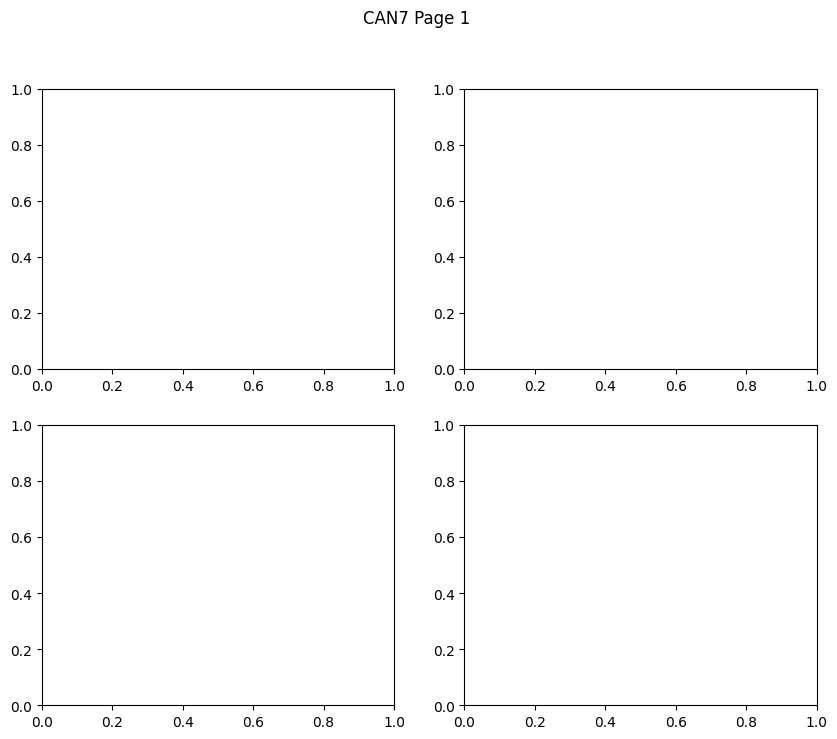

In [14]:
# plot distributions

from ipywidgets import interact, IntSlider

# Sample data: Creating a list of DataFrames with random 'step_time' data
# data_frames = [pd.DataFrame({'step_time': np.random.normal(loc=i*10, scale=5, size=100)}) for i in range(10)]
CAN_LIST=list(msgs1_df.keys())
MSGS_LIST=[list(msg.keys()) for can, msg in msgs1_df.items()]
# Function to plot distributions with pagination

def plot_distributions(can_id=0,page_num=0):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f"{CAN_LIST[can_id]} Page {page_num + 1}")

    # Flatten axes array for easier indexing
    axes = axes.flatten()
    data_frames=[df for msg, df in msgs1_df[CAN_LIST[can_id]].items()]
    data_frames_titles=MSGS_LIST[can_id]
    # Calculate the start and end index of the data frames to display on this page
    start_idx = page_num * 4
    end_idx = min(start_idx + 4, len(data_frames))

    # Plot each data frame in a subplot
    for i in range(4):
        axes[i].clear()  # Clear previous plots
        if start_idx + i < end_idx:
            df = data_frames[start_idx + i]
            axes[i].hist(df['dT'], bins=20, color='skyblue', edgecolor='black')
            # axes[i].set_title(f'DataFrame {start_idx + i + 1}')
            axes[i].set_title(f'{data_frames_titles[start_idx + i]}')
        else:
            axes[i].axis('off')  # Hide unused subplots

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
    plt.show()




# Number of pages required
num_pages = (len(MSGS_LIST[0]) + 3) // 4

can_widget = IntSlider(min=0, max=len(CAN_LIST)-1, step=1)
page_widget = IntSlider(min=0, max=num_pages, step=1)
msgs_widget = IntSlider(min=0, max=len(MSGS_LIST[0])-1, step=1, value=0)


# 

    
def update_pages_range(*args):
    num_pages = (len(MSGS_LIST[can_widget.value]) + 3) // 4
    page_widget.max=num_pages
    
can_widget.observe(update_pages_range, 'value')
interact(plot_distributions,can_id=can_widget, page_num=page_widget);


# Interactive widget to scroll through pages
# interact(plot_distributions, page_num=IntSlider(value=0, min=0, max=num_pages - 1));

# def update_msgs_range(*args):
#     msgs_widget.max = len(MSGS_LIST[can_widget.value])-1

# can_widget.observe(update_msgs_range, 'value')
# def printer(can_id, msg_id):
#     can=CAN_LIST[can_id]
#     msg=MSGS_LIST[can_id][msg_id]
#     print(can,msg)
    
# interact(printer,can_id=can_widget, msg_id=msgs_widget);


# for can,can_msgs in msgs1_df.items():
#     # print(can)
    
#     for msg, grp in can_msgs.items():
        

In [ ]:
CAN_ID='CAN1'
SA_ID='90'
sigs_names=['DTS_Status1.DTS_VehicleSpeed',
'VSMState.VSM_Substate',
'VSMState.VSM_State',
'GS_State.GS_Est_State',
'VSM_DEBUG_OUT_1.VSM_Int_InitDecision',
'ModuleAlive.ModuleUptime','NO_MSG.NO_SIG']
sigs_sel=defaultdict(list)
for sig_name in sigs_names:
    (msg, sig)= sig_name.split('.');
    if sig in mdf1_can_sa_msgs_sigs_idx[CAN_ID][SA_ID][msg]:
        (grp_idx,ch_idx)=mdf1_can_sa_msgs_sigs_idx[CAN_ID][SA_ID][msg][sig]
        # mdf_sig=mdf1_extracted.select([(None,grp_idx,ch_idx)])[0]
        # mdf_sig=mdf1_extracted.get((None,grp_idx,ch_idx))[0]
        mdf_sig=mdf1_extracted.get(group=grp_idx,index=ch_idx)
        sigs_sel[sig_name]=mdf_sig
        mdf_sig.plot()
    else:
        sigs_sel[sig_name]=None


# for sig in sigs_sel:
#     sig.plot()
        

In [ ]:
mdf1_extracted_df=mdf1_extracted.to_dataframe(use_display_names=True,use_interpolation=False)
mdf2_extracted_df=mdf2_extracted.to_dataframe(use_display_names=True,use_interpolation=False)
mdf1_extracted_df = decode_bytes(mdf1_extracted_df)
mdf2_extracted_df = decode_bytes(mdf2_extracted_df)
# mdf1_extracted_df_inter=mdf1_extracted.to_dataframe(use_display_names=True,use_interpolation=True)
# mdf1_extracted_df_inter = decode_bytes(mdf1_extracted_df_inter)


In [ ]:
# different export options
# mdf 
mdf1_extracted.export(fmt='hdf5',filename='output/mdf1_extracted')
# data frames
mdf1_extracted_df.to_csv('output/mdf1_extracted_df.csv')
# mdf1_extracted_df_inter.to_csv('output/mdf1_extracted_df_inter.csv')
mdf2_extracted_df.to_csv('output/mdf2_extracted_df.csv')

# this one is the best - it already stores all information with normal memory usage
mdf1_extracted.save('output/mdf1_extracted')


In [ ]:
# plot main signals to compare log
sigs_names=['CAN2.VSMState.VSM_State',
'CAN2.GS_State.GS_Est_State',
'CAN2.DTS_Status1.DTS_VehicleSpeed']
# df=mdf1_extracted.to_dataframe(channels=sigs_names,use_display_names=True,use_interpolation=True)
# df=decode_bytes(df)
df_list=[mdf1_extracted_df,mdf2_extracted_df]

subplot_titles = [title for title in sigs_names for _ in range(2)]
# subplot_titles=sigs_names
                  
fig = make_subplots(rows=3, cols=2, shared_xaxes=True,subplot_titles=subplot_titles)

for j, df in enumerate(df_list,1):
    # opacity=0.7 if j==2 else 1
    opacity=1
# Plot each column as a separate subplot
    for i, col in enumerate(sigs_names, 1):  # i goes from 1 to 3 (subplot row indices)
        sig = df[col].dropna()
        fig.add_trace(
            go.Scatter(x=sig.index,y=sig.values, mode='markers+lines', name=col,opacity=opacity),
            row=i, col=j
        )

# Update layout
fig.update_layout(
    title="Vehicle main states",
    height=600,
    showlegend=False,  # Hide legend for clarity
)

# Show plot
fig.show()

In [ ]:
sigs1=mdf1_extracted_df.columns.to_list()
sigs2=mdf2_extracted_df.columns.to_list()

# msgs1_sig={tuple(sig.split('.')[1:]):idx for idx,sig in enumerate(sigs1)};
# msgs1 = {key[0] for key in msgs1_sig};
msgs1_sig={tuple(sig.split('.')):idx for idx,sig in enumerate(sigs1)};
msgs1 = {key[1] for key in msgs1_sig};

# msgs2_sig={tuple(sig.split('.')[1:]):idx for idx,sig in enumerate(sigs2)};
# msgs2 = {key[0] for key in msgs2_sig};
msgs2_sig={tuple(sig.split('.')):idx for idx,sig in enumerate(sigs2)};
msgs2 = {key[1] for key in msgs2_sig};
# msgs1_k=tuple(msgs1);  

In [ ]:
# compare by keys
# for k in msgs1:
#     if not k in msgs2:
#         print(f"{k} not in msgs2")
        
# for k in msgs2:
#     if not k in msgs1:
#         print(f"{k} not in msgs1")  

# compare by keys
for k in msgs1_sig:
    if not k in msgs2_sig:
        print(f"{k} not in msgs2")
        
for k in msgs2_sig:
    if not k in msgs1_sig:
        print(f"{k} not in msgs1") 

In [ ]:
def compare_with_tolerance(val1, val2, abs_tolerance=None, rel_tolerance=None):
    # if isinstance(val1, tuple):
       
    if type(val1).__module__ == np.__name__:
        values1=[val1.tolist()]
        values2=[val2.tolist()]
    elif isinstance(val1, tuple):
        values1 = list(val1)
        values2 = list(val2)
    else:
        values1=[val1]
        values2=[val2]
        
        
    for idx,val in enumerate(values1):
        abs_diff = abs(values1[idx] - values2[idx])
        if abs_tolerance:
        
            # Calculate the absolute difference
            
            # Check if the absolute difference is within the absolute tolerance
            if abs_diff >= abs_tolerance:
                return True
            
        if rel_tolerance:
            # Calculate the relative difference
            rel_diff = abs_diff / max(max(abs(values1[idx]), abs(values2[idx])),0.001)
            
            # Check if the relative difference is within the relative tolerance
            return rel_diff >= rel_tolerance
    return False

In [ ]:
template_stat_dict = {'mean':None,'min':None,'max':None,'std':None,'std_rel':None,'nobs':None,'x':None}

def get_stat_vals(x):
    stat_vals=template_stat_dict.copy()
    if (x is not None):
        if (x.size>0):
            stat_vals={'mean':np.mean(x),'min':np.min(x),'max':np.max(x),
                       'std':np.std(x),'nobs':len(x),'x':x}
            if (abs(stat_vals['mean'])>0):
                stat_vals['std_rel']=abs(stat_vals['std']/stat_vals['mean'])
    return stat_vals

def get_stat_vals_diff(msgs):
    msg1=msgs['msg1']
    msg2=msgs['msg2']
    stat_vals=template_stat_dict.copy()
    
    
    if (msg1['mean'] is not None) & (msg2['mean'] is not None):
        for k in stat_vals:
            if k=='x':
                continue
            stat_vals[k]=msg1[k]-msg2[k]
            
        # stat_vals={'mean':abs(msg1['mean']-msg2['mean']),'min':abs(msg1['min']-msg2['min'])
                #    ,'max':abs(msg1['max']-msg2['max']),'std':abs(msg1['std']-msg2['std']),'nobs':abs(msg1['nobs']-msg2['nobs'])}
        
    return stat_vals

In [ ]:
sigs2exclude=['counter','checksum','CheckSum','MsgCnt','MsgCks','MsgCtr','_cnt','_sum','_CRC','SpdCRC','GS_MC','GS_CRC']
valstat2incl=['mean','min','max','std','top','count','unique']
timestat2incl=['minmax','mean']
sigs2exclude=[s.lower() for s in sigs2exclude]
pattern = re.compile(r'|'.join(re.escape(value) for value in sigs2exclude))
# compare by value
# time_stat_val={'mean':None,'min':None,'max':None,'std':None}
msg_stats_temp={'msg1':get_stat_vals(None),'msg2':get_stat_vals(None),'diff':get_stat_vals(None)}
msg_stats={}
for msg in msgs1:
    print(f"\n\nmsg: {msg}")
    if msg not in msgs2:
        print(f"no msg {msg} in msg2 ")
        continue
    # msgs_sigs = [(msg_name, sig_name) for (msg_name, sig_name)  in msgs1_sig.keys() if msg_name == msg]
    msgs_sigs = [(can_num,msg_name, sig_name) for (can_num,msg_name, sig_name)  in msgs1_sig.keys() if msg_name == msg]
    for msg_sig in msgs_sigs:
        (can_num,msg_name,sig_name)=msg_sig
        
        if (pattern.search(msg_sig[2].lower())):
            print(f"exlude by rule: {msg_sig}")
            continue
        
        if msg_sig in msgs2_sig:
            
            val1=mdf1_extracted_df.iloc[:,msgs1_sig[msg_sig]].dropna()
            val2=mdf2_extracted_df.iloc[:,msgs2_sig[msg_sig]].dropna()

            val1_s=val1.describe()
            val2_s=val2.describe()
            is_new_sig=True
            
            for d_k, d_v in val1_s.items():
                if d_k not in valstat2incl:
                    continue
                if d_k in val2_s:
                    if d_v != val2_s[d_k]:
                        if is_new_sig:
                            print(f"\nmsg_sig: {msg_sig}")
                            is_new_sig=False
                            
                        print(f"{d_k}: {d_v} -> {val2_s[d_k]}")
                else:
                    if is_new_sig:
                            print(f"\nmsg_sig: {msg_sig}")
                            is_new_sig=False
                    print(f"values no stat {d_k}")
            
            
            # time analysis
            can_msg= (can_num,msg_name)
            if can_msg not in msg_stats:
                
                msg_stats[can_msg]=msg_stats_temp.copy()
                t1=val1.index.to_numpy()
                t2=val2.index.to_numpy()
                dt1=np.diff(t1)
                dt2=np.diff(t2)

                    
                # dt1_stat=stats.describe(dt1)
                # dt2_stat=stats.describe(dt2)
                # msg_stats[can_msg]['msg1_dt']=dt1
                # msg_stats[can_msg]['msg2_dt']=dt2
                
                # msg_stats[can_msg]['msg1_dt']=dt1[0:5]
                # msg_stats[can_msg]['msg2_dt']=dt2[0:5]
                
                msg_stats[can_msg]['msg1']=get_stat_vals(dt1)
                msg_stats[can_msg]['msg2']=get_stat_vals(dt2)
                msg_stats[can_msg]['diff']=get_stat_vals_diff(msg_stats[can_msg])
                is_new_time=True
                if dt1.size==0:
                    print('t1 no data')
                    continue
                if dt2.size==0:
                    print('t2 no data')
                    continue
                
                for d_k  in msg_stats[can_msg]['msg1']:
                    if d_k=='x':
                        continue
                    
                    d_v1=msg_stats[can_msg]['msg1'][d_k]
                    d_v2=msg_stats[can_msg]['msg2'][d_k]
                    
                    if compare_with_tolerance(d_v1,d_v2,None,0.01):
                        if is_new_sig:
                            print(f"\nmsg_sig: {msg_sig}")
                            is_new_sig=False
                        if is_new_time:
                            print('time stat:')
                            
                        print(f"{d_k}\n{d_v1}\n{d_v2}")
                        # print(f"{d_k}:")
                        # print(tabulate([d_v1,d_v2]))
                
            
        else:
            print(f"{msg_sig} not in msgs2")


# df=pd.concat({
#         k: pd.DataFrame.from_dict(v, 'index') for k, v in msg_stats.items()
#     }, 
#     axis=0)

export to files

In [ ]:
# prepare dict - convert keys from tuple

# msg_stats1 = {".".join(key): value for key, value in msg_stats.items()};

In [ ]:
# original as it is formats

# import pickle 
# import json 
# np.save('output/msg_stats.npy', msg_stats1) 

# with open('output/msg_stats.pkl', 'wb') as f:
#     pickle.dump(msg_stats1, f)

# # to Json format
# class NumpyEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return super().default(obj)
    
# with open("output/msg_stats.json", "w") as outfile: 
#     json.dump(msg_stats1, outfile,cls=NumpyEncoder)



In [ ]:
# # convert to table
# df = pd.DataFrame.from_dict(msg_stats1, orient='index')
# df.head();

In [ ]:
# def myunpack(x):
#     y=[{**{'can_msg': can_msg},
#                     **stats} for can_msg,
#                    stats in x.items()]
#     return y
# msg_stat1_flat=myunpack(msg_stats1);
# df = pd.DataFrame(msg_stat1_flat)
# df.head();

# df2 = pd.DataFrame.from_dict(msg_stat1_flat)
# df2.head();


In [ ]:
# msg stat processing - make table and add calculated values

msg_stats1={}
for can_msg_key, msg in msg_stats.items():
    # row=[]
    msg_idx=".".join(can_msg_key)
    # row.append(msg_indx)
    if msg_idx not in msg_stats1:
        msg_stats1[msg_idx] = {}
        
    for msg_k, msg_num_item in msg.items():
        for stat_k, stat_item in msg_num_item.items():
            stat_idx=msg_k+'.'+stat_k
            msg_stats1[msg_idx][stat_idx]=stat_item

msg_df = pd.DataFrame.from_dict(msg_stats1, orient='index')
msg_df.index.name='CAN.MSG'
msg_df[('msg1.std_rel_prc')]=msg_df['msg1.std_rel']*100
msg_df[('msg2.std_rel_prc')]=msg_df['msg2.std_rel']*100
msg_df[('diff.mean_rel')]=abs(msg_df[('diff.mean')]/(msg_df[('msg1.mean')])*100)

msg_df.sort_values(by=('diff.mean_rel'),inplace=True,ascending=False)
msg_df.head(10);




In [ ]:
# export to file
import csv
np.set_printoptions(threshold=sys.maxsize)

# Function to format NumPy arrays as a consistent string
def format_array(arr):
    if isinstance(arr, np.ndarray):
        s="["+' '.join(f'{x:.6f}' for x in arr) + "]"
        return s  # Set precision to 6 decimals, for example
        # return np.array2string(arr, precision=5, separator=' ',max_line_width = None,
                    #   suppress_small=True)
    return arr  # Leave non-arrays unchanged

# Apply formatting function to each element
df = msg_df.map(format_array)
df.head();

df.to_csv('output/msg_stats_df.csv',quoting= csv.QUOTE_NONNUMERIC)


In [ ]:

# import pygwalker as pyg
# msg_df1 = msg_df.reset_index()
# walker = pyg.walk(msg_df1)

In [ ]:
# msg_df.sort_index(inplace=True)

# for idx, row in msg_df.head(1).iterrows():
#     plt.figure(figsize=(8, 4))
#     # plt.hist(row['msg1.x'], bins=10, alpha=0.5, label=f"msg1.dt: nobs={row['msg1.nobs']}", color='blue',density=True)
#     # plt.hist(row['msg2.x'], bins=10, alpha=0.5, label=f"msg2.dt: nobs={row['msg2.nobs']}", color='orange',density=True)
#     plt.hist(row[['msg1.x','msg2.x']], bins=10, alpha=0.5, density=True)
#     # plt.hist(row['msg2.x'], bins=5, alpha=0.5, label='msg2.dt', color='orange')
#     # plt.text(0,0,f"{row['msg1.nobs']}")
#     plt.title(f"Distribution for {idx}")
#     plt.xlabel("Value")
#     plt.ylabel("Frequency")
#     plt.legend(loc="upper right")
#     plt.show()

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.express as px
# row=msg_df.iloc[0]
# # fig=px.histogram(x=row["msg1.x"],histnorm="probability")
# # fig=px.histogram(msg_df,x="msg1.x",histnorm="probability")
# # fig=px.histogram(x=row["msg2.x"],histnorm="probability")
# # fig = go.Figure()
# # fig.add_trace(go.Histogram(histfunc="count", y=y, x=x, name="count"))
# # fig.add_trace(go.Histogram(histfunc="sum", y=y, x=x, name="sum"))
# # fig = go.Figure()
# # fig.add_trace(px.histogram(x=row["msg1.x"],histnorm="probability"))
# # fig.add_trace(px.histogram(x=row["msg2.x"],histnorm="probability"))

# fig = go.Figure()
# fig.add_trace(go.Histogram(x=row["msg1.x"]))
# fig.add_trace(go.Histogram(x=row["msg2.x"]))

# # The two histograms are drawn on top of another
# fig.update_layout(barmode='stack')

# fig.show()

In [ ]:
msg_df1=msg_df[(msg_df['diff.mean_rel']>1) | (msg_df['msg1.nobs']<1) |  (msg_df['msg2.nobs']<1)]
cols2prnt=['diff.mean_rel','msg1.mean','msg2.mean','msg1.nobs','msg2.nobs']
print(msg_df1[cols2prnt])

In [ ]:

import plotly.express as px
fig = px.bar(msg_df1, x=['diff.mean_rel'],hover_data=['msg1.mean','msg2.mean','msg1.nobs', 'msg2.nobs'], text_auto='.2',barmode='group',
            title="msgs times")
# fig = px.box(msg_df, y=['msg1.mean','msg2.mean'],hover_data=['msg1.nobs', 'msg2.nobs'], 
#             title="msgs times")
fig.show()

Process all messages without decoding at first

In [ ]:
file=r'C:\D\downloads\VI-15803\R11_canlog_50638_20240926_142426.mf4'
# f1_time=[0,100] # selection of the log

# mdf1=mdf1.cut(f1_time[0],f1_time[1],whence=1,time_from_zero=1)

In [ ]:
mdf = MDF(file1)
all_can_msgs = utls.get_all_messages(mdf,False)
# all_can_msgs2 = utls.get_all_messages(mdf2,False)

In [ ]:
# process prepare tables


# all_can_msgs = all_can_msgs1
# for all_can_msgs in [all_can_msgs1, all_can_msgs2]:
# for all_can_msgs in [all_can_msgs1]:
msg_keys_to=['CAN_Bus', 'msg_id', 'is_extended', 'msg_pgn', 'msg_sa'] #+'msg_dt_stat'
dt_stat_keys_to=['mean', 'min', 'max', 'std','std_rel', 'nobs']

msg_d=[]
for key,msg in all_can_msgs.items():
    # key;
    # msg=all_can_msgs[key]
    dt=np.diff(msg['msg_time'])
    msg_dt_stat=get_stat_vals(dt)
    # msg['msg_dt']=dt
    msg['msg_dt_stat']=msg_dt_stat
    
    # prepare dict with essential info
    row={}
    # row['idx']=key
    for msg_k_to in msg_keys_to:
        row[msg_k_to]=msg[msg_k_to]
    
    for dt_stat_k_to in dt_stat_keys_to:
        row['dt_'+dt_stat_k_to]=msg_dt_stat[dt_stat_k_to]
    
    msg_d.append(row)


mdf_df = pd.DataFrame(msg_d)
mdf_df.set_index(['CAN_Bus','msg_id','is_extended'],inplace=True,drop=False)
# mdf_df.set_index(['idx'],inplace=True)

#  add meta info
mdf_df.attrs["mdf.file_history"]=str(mdf.file_history)
mdf_df.attrs["mdf.start_time"]=mdf.start_time
mdf_df.attrs["mdf.name"]=mdf.name


mdf_df.attrs;
mdf_df.head();




In [ ]:
f1_time=[0,10] # selection of the log
file1=r'C:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\input\r11_D19\R11_canlog_50640_20240926_142715.mf4'
file2=r'C:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\input\r12_D19\canlog_51940_20241107_122852.mf4'

(_,mdf_df1)=utls.get_mdf_msgs(file1,f1_time)
(_,mdf_df2)=utls.get_mdf_msgs(file2,f1_time)

mdf_df1.attrs;
mdf_df1.head();

mdf_df2.attrs;
mdf_df2.head();

In [ ]:
mdf_df12=mdf_df1.reindex(mdf_df2.index).fillna('NOT')
mdf_df21=mdf_df2.reindex(mdf_df1.index).fillna('NOT')

print('compare 1 vs 2')
mdf_df12_CMP=mdf_df1.compare(mdf_df21,result_names=('f1','f2'));

print('compare 2 vs 1')
mdf_df21_CMP=mdf_df2.compare(mdf_df12,result_names=('f2','f1'));

id diff - find new id

In [ ]:
df1_can_id=mdf_df1['CAN_Bus'].unique();
df2_can_id=mdf_df2['CAN_Bus'].unique();

for can_id in df1_can_id:
    if not can_id in df2_can_id:
        print(f"CAN_Bus not in file: {can_id}")
        continue
    else:
        # msgs1=mdf_df1[mdf_df1['CAN_Bus']==can_id]
        # msgs2=mdf_df1[mdf_df1['CAN_Bus']==can_id]
        msgs1_id=set(mdf_df1.loc[can_id]['msg_id'])
        msgs2_id=set(mdf_df2.loc[can_id]['msg_id'])
        new_msg_id=msgs2_id-msgs1_id
        if len(new_msg_id)>0:
            print(f"CAN: {can_id} New msg_id: {len(new_msg_id)}")
            print(new_msg_id)
        # first_level_df1 = set(msgs1.index.get_level_values('msg_id').unique())      


In [ ]:
# another way to do it
idx1_new=mdf_df1.index.difference(mdf_df2.index)
idx2_new=mdf_df2.index.difference(mdf_df1.index)
idx12_common=mdf_df1.index.intersection(mdf_df2.index)


In [ ]:
# combine dataframes
cols2merge=['CAN_Bus','msg_id','is_extended','msg_pgn','msg_sa']
# cols_common=['msg_pgn','msg_sa']
cols2join=['dt_mean','dt_std_rel','dt_nobs']
mdf_df1_c=mdf_df1.copy().reset_index(drop=True)
mdf_df2_c=mdf_df2.copy().reset_index(drop=True)

# select only common columns and joined
mdf_df1_c=mdf_df1_c[cols2merge + cols2join]
mdf_df2_c=mdf_df2_c[cols2merge + cols2join]

cols_f1={col:f'f1.{col}' for col in cols2join}
cols_f2={col:f'f2.{col}' for col in cols2join}
mdf_df1_c.rename(columns=cols_f1,inplace=True)
mdf_df2_c.rename(columns=cols_f2,inplace=True)
mdf_df_c=mdf_df1_c.merge(mdf_df2_c,'outer',left_on=cols2merge,right_on=cols2merge,suffixes=('.f1','.f2'),indicator=True)

# restore index
mdf_df_c.set_index(['CAN_Bus','msg_id','is_extended'],inplace=True,drop=False)

# update status  category
STATUS=['NEW IN F1','NEW IN F2','DT DIFF','EQUAL']
# mdf_df_c['STATUS']=pd.Categorical(STATUS)
mdf_df_c['STATUS']=''

mdf_df_c.loc[idx1_new,'STATUS']='NEW IN F1'
mdf_df_c.loc[idx2_new,'STATUS']='NEW IN F2'

# calculate diff

for col in cols2join:
    mdf_df_c.loc[idx12_common,f'diff.{col}']=round((mdf_df_c.loc[idx12_common,f'f1.{col}']-mdf_df_c.loc[idx12_common,f'f2.{col}'])/mdf_df_c.loc[idx12_common,f'f1.{col}']*100,2)
    

mdf_df_c.sort_values(by='diff.dt_mean',ascending=False,inplace=True)

# diff thresholds
dT_th=5# 5% threshold
mdf_df_c.loc[mdf_df_c['diff.dt_mean']>dT_th,'STATUS']+='+DT DIFF'
mdf_df_c.loc[mdf_df_c['diff.dt_std_rel']>dT_th,'STATUS']+='+DT STD DIFF'
mdf_df_c.loc[mdf_df_c['diff.dt_nobs']>dT_th,'STATUS']+='+DT NOBS DIFF'

mdf_df_c.head()


In [ ]:
# analyze change of time stat
for can_id in df1_can_id:
    if not can_id in df2_can_id:
        print(f"can not in file {can_id}")
        continue
    else:
        msgs1=mdf_df1.loc[can_id]
        msgs2=mdf_df1.loc[can_id]
        for id, msg1 in msgs1.iterrows():
            if not id in msgs2.index:
                continue
            msg2=msgs2.loc[id]
            
        

# load datas into databases (duck db)

In [ ]:
# import duckdb
# import glob
# folder_path = r"C:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\output\export"
# db_path=r'C:\D\work\py_work\UCSDT_utils\can_log_mdf_parse\output\mydb.duckdb'
# con = duckdb.connect(db_path)

In [ ]:
# for csv_file in glob.glob(folder_path + "\*.csv"):
#     # Extract the base name to use as table name
#     table_name=os.path.basename(csv_file)
#     table_name, _ = os.path.splitext(table_name)
#     table_name=table_name.replace('.','_')
#     csv_file_txt=print(csv_file)
#     sql_txt=f"CREATE TABLE {table_name} AS SELECT * FROM read_csv('{csv_file}')";
    
#     # Load CSV into a new table
#     con.execute(sql_txt)
#     print(f"Loaded {csv_file} into table '{table_name}'")


In [ ]:
# tables = con.execute("SHOW TABLES").fetchall()
# print("Loaded Tables:", tables)